# ADCP Analysis

In [52]:
import xarray as xr
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import cartopy.crs as ccrs
import cmocean
import numpy as np
from geopy import distance
import datetime as dt
import pandas as pd
import scipy
import gsw

## Functions 

In [2]:
def dist_shore(adcp, lon0,lat0):   # Calculate the distance from each measurement to the coast and add it as variable to the dataset.
    adcp_surf = adcp.isel(trajectory=0).compute()
    d = xr.zeros_like(adcp_surf.lon)
    #lon0, lat0 = adcp_surf.lon.data[-1], adcp_surf.lat.data[-1]
    for ob, (lon, lat) in enumerate(zip(adcp_surf.lon.data, adcp_surf.lat.data)):
        d[ob] = distance.distance((lon, lat), (lon0, lat0)).km
        adcp["s"] = d.assign_attrs(
        {"long_name": "distance to coast", "units": "km", "positive": "off shore"}
    )
    adcp = adcp.set_coords("s").sortby("s")
    #print(f"max distance from coast: {abs(adcp.s.min()).data / 1000:.2f} km")
    return adcp

In [3]:
#Cross-shore and longshore velocity plots functions

def horiz_vel(adcp, title):
    
   
    # Calculate and plot the velocity components parallel and perpendicular to the coast.
    adcp_surf = adcp.isel(trajectory=36).compute()
    # calculations
    
    angle = np.arctan2(lat_3_shore - lat_1_shore,lon_3_shore - lon_1_shore)  # Angle of alongshore direction (
    
    # Compute cross-shore and alongshore velocity components using sines and cosines
    Ulong = adcp.U * np.cos(angle) + adcp.V * np.sin(angle)
    Ucross = -adcp.U * np.sin(angle) + adcp.V * np.cos(angle)
    
    adcp["Ucross"] = Ucross.assign_attrs(
        {"long_name": "cross-shore velocity", "units": "m s-1"}
    )
    adcp["Ulong"] = Ulong.assign_attrs(
        {"long_name": "longshore velocity", "units": "m s-1"}
    )
    
    # figure settings
    fig = plt.figure(figsize=(10, 6))
    fig.suptitle(f'{title}', fontsize=14) 
    norm = mcolors.CenteredNorm(halfrange=2)
    cmap = cmocean.cm.balance
    #landmask = xr.where(((adcp.U == 0) & (adcp.V == 0)), 1, np.nan)
    #S = adcp.s.broadcast_like(adcp.lon)
    
    # cross-shore velocity plot
    ax1 = fig.add_subplot(121)
    #plot adcp velocities
    p = ax1.pcolormesh(adcp.s, adcp.z, adcp.Ucross, norm=norm, cmap=cmap)
    #plot ctd isothermos 
    #
    fontsize = 12
    inline =0.5
    inline_sp = 10
    linewidth=3
    #plot ctd isothermos 
    #temp = ax1.contour(ctd_trs1.lon, ctd_trs1.z, ctd_trs1.temperature,colors = 'black',linewidths= 0.7, linestyles='-')
    #ax1.clabel(temp,inline= inline,fontsize = fontsize,colors='black',inline_spacing = inline_sp)
    #plot contours of equal velocity 
    levs = np.arange(-2, 2, 0.2)
    vel = ax1.contour(adcp.s, adcp.z, adcp.Ucross,colors='white',linewidths= 1.6, linestyles='-', levels= levs)
    ax1.clabel(vel,inline= inline,fontsize = fontsize,colors='white',inline_spacing = inline_sp)
   # p = ax1.pcolormesh(S / 1000, adcp.z, adcp.Ucross, norm=norm, cmap=cmap)
    #ax1.pcolormesh(S / 1000, adcp.z, landmask, cmap="binary_r")
    ax1.set_ylabel("depth [m]")
    ax1.set_xlabel("distance from coast [km]")
    ax1.set_title("cross-shore velocity (positive on-shore)")
    ax1.grid()
    #plt.xlim([0,-600])
    
    # alongshore velocity plot
    ax2 = fig.add_subplot(122, sharey=ax1)
    ax2.yaxis.tick_right()
    p2 = ax2.pcolormesh(adcp.s, adcp.z, adcp.Ulong, norm=norm, cmap=cmap)
    #plot ctd isothermos 
    #temp = ax2.contour(ctd_trs1.lon, ctd_trs1.z, ctd_trs1.temperature,colors = 'black',linewidths= 0.7, linestyles='-')
    #ax2.clabel(temp,inline= inline,fontsize = fontsize,colors='black',inline_spacing = inline_sp)
    #plot contours of equal velocity 
    levs = np.arange(-2.5, 2.5, 0.5)
    vel = ax2.contour(adcp.s, adcp.z, adcp.Ulong,colors='white',linewidths= 1.6, linestyles='-', levels= levs)
    ax2.clabel(vel,inline= inline,fontsize = fontsize,colors='white',inline_spacing = inline_sp)
    #p2 = ax2.pcolormesh(S / 1000, adcp.z, adcp.Ulong, norm=norm, cmap=cmap)
   # ax2.pcolormesh(S / 1000, adcp.z, landmask, cmap="binary_r")
    ax2.set_ylabel("depth [m]", rotation=270, labelpad=15)
    ax2.set_xlabel("distance from coast [km]")
    ax2.set_title("longshore velocity (positive with coast on l.h.s.)")
    ax2.yaxis.set_label_position("right")
    ax2.grid()
    fig.colorbar(
        p, ax=[ax1, ax2], shrink=0.7, orientation="horizontal", label=r"m s$^{-1}$"
    
    )
   # plt.xlim([0, -600])

In [4]:
def vertical_vel(data, title):
    peru = data
    peru_d = peru.sortby("z", ascending=False)  # sort downward
    norm = mcolors.CenteredNorm(halfrange=1)
    cmap = cmocean.cm.balance
    # # compute dwdz - easy central difference method
    # dwdz = -peru_d.Ucross.differentiate('s')
    
    # compute dwdz - central difference using interpolated values at cell edges
    # slightly more accurate
    landfilter = xr.where(
    ((peru_d.U == 0) & (peru_d.V == 0)), 0, 1
    )  # 0 in land, 1 in ocean
    Ucrossi = peru_d.Ucross.interp(
    obs=peru_d.obs - 0.5
    )  # U at cell boundaries (toward ocean)
    Ucrossi = Ucrossi * landfilter.data
    dUcrossds = Ucrossi.diff("obs") / Ucrossi.s.diff("obs")
    dwdz = -dUcrossds
    
    # integrate dwdz
    peru["w"] = dwdz.cumulative_integrate("z")
    
    # plot the vertical velocity
    ax = plt.axes()
    S, Z = xr.broadcast(-peru.s , peru.z)
    w = ax.pcolormesh(S, Z, peru.w.T, norm=mcolors.CenteredNorm(), cmap=cmap)
    ax.pcolormesh(S, Z, landmask.T, cmap="binary_r")
    plt.title("vertical velocity")
    plt.ylabel("depth [m]")
    plt.xlabel("shoreward distance [km]")
    #plt.xlim([-350, 0])
    plt.colorbar(w, label=r"m s$^{-1}$")

## Ship Route

In [5]:

#loading the dta
adcp = xr.open_zarr("/Users/areti/Downloads/results2/somalia/results/adcp.zarr").compute()
#/Users/areti/OneDrive/Desktop/UU/OcenDyn/virtual_ship_data/results/results/adcp.zarr").compute()

# for convenience, define z positive upward
#zu = np.unique(-adcp.z, axis=1).squeeze()  # convert z to 1D and positive upward
zu = np.unique(adcp.z, axis=1).squeeze()  # convert z to 1D 
adcp = adcp.assign_coords({"z": ("trajectory", zu)}).sortby("z")

#bathymetry, thanks Tssa! :)
bathy = xr.open_dataset("/Users/areti/OneDrive/Desktop/UU/OcenDyn/virtual_ship_data/gebco_2024_n11.0_s3.0_w44.0_e57.0.nc")
bathy_masked = bathy.elevation.where(bathy.elevation <= 0)

In [6]:
#to calculate the distance from the shore later, I manually selected these points from the nioz tool. These are approximately the coordinades of the 
#shore if you extend our transects. 

#shore lon and lat (extension for transect 1)
lon_1_shore = 48.21
lat_1_shore = 4.97
#shore lon and lat (extension for transect 2)
lon_2_shore = 49.54
lat_2_shore = 7.29
#shore lon and lat (extension for transect 3)
lon_3_shore = 50.72
lat_3_shore = 9.31

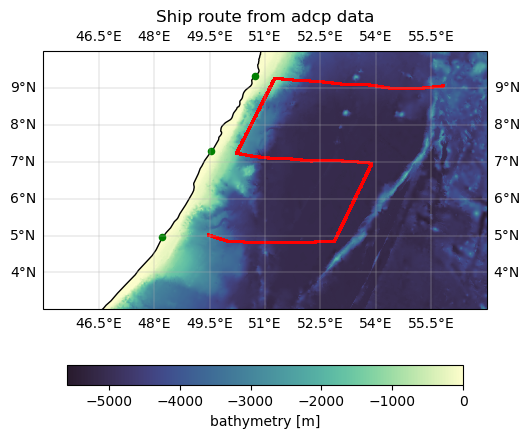

In [7]:
# plot track
ax = plt.axes(projection=ccrs.PlateCarree())
ax.scatter(adcp.lon, adcp.lat, transform=ccrs.PlateCarree(), marker = 'o', s= 1, color = 'red',zorder=2)
#plotshore
ax.scatter(lon_1_shore, lat_1_shore,  transform=ccrs.PlateCarree(), marker = 'o', s= 20, color = 'green',zorder=2)
ax.scatter(lon_2_shore, lat_2_shore, transform=ccrs.PlateCarree(), marker = 'o', s= 20, color = 'green',zorder=2)
ax.scatter(lon_3_shore, lat_3_shore, transform=ccrs.PlateCarree(), marker = 'o', s= 20, color = 'green',zorder=2)
# Plot bathymetry
cm = ax.pcolormesh(bathy.lon, bathy.lat, bathy_masked, cmap=cmocean.cm.deep_r, shading='auto', zorder=1)
ax.coastlines()
ax.gridlines(draw_labels=True,linewidth=0.3)
ax.set_extent((45, 57, 3, 10))
ax.set_title("Ship route from adcp data")
plt.colorbar(cm,location='bottom',shrink=0.8, label = 'bathymetry [m]')

## Slicing the data into transects

So apparently the structure of the data was quite weird (to me), and the observations weren't linearly in time. In this section I am doing a little detour trying to slice our data into the three transects we have. 

The 'time' is a variable/observation in this adcp dataset. I am attempting to access a datapoint via the obs coordinate. We have 1732 observations. 

Based on the dates ('time' variable) I tried to pinpoint which obs (observations? I guess) correspond to the start and end time of each transect. 

In [8]:
#Check the number of obervations 
num_obs = adcp.obs.shape
num_obs[0]
obs = list(range(0,num_obs[0]))
print('Number of observtions is', num_obs[0])

Number of observtions is 1732


In [9]:
#the dates of the transects, first and last measurments 
dates = pd.to_datetime(adcp.time[0][:].values)
dates = pd.DataFrame(dates, columns=['Time'])

#the tim a an offset of 1 to a couple minutes due to the 5min interval between adcp measurments
#Transect 1
trs_1_start = '2024-09-17 23:12:00'
trs_1_end = '2024-09-19 10:02:00'

#Transect 2
trs_2_start = '2024-09-20 02:07:00'
trs_2_end = '2024-09-21 14:12:00'

#Transect 3

trs_3_start = '2024-09-22 05:57:00'
trs_3_end = '2024-09-23 23:12:00'

dates['index'] = obs #keeping the original index, this is the number of observation as saved in the dataset

The observation dates were shuffled (I am not sure why this has happened). Notice in the following cell how the datesj ump back and forth in time!

This means that by just doing data = adcp.sel(obs=slice(0:400)) I am not getting the observations of lets say 2024-09-17 to 2024-09-19 asI expected, but i get some random other dates mixed in with it. 

Ikeep the original index of the obs, sort the Time to be linear and use a new index to actually slice the data like I wanted. This way I end up with an array that has the obs index corresponding to the linear dates I want. So e.g 2024-09-17 to 2024-09-19 and obs = [0,1,2,3,56,57,58,4,5,6...,400] (random numbers for demonstration)

In [10]:
dates[400:410]

,Time,index
400,2024-09-19 08:32:00,400
401,2024-09-19 08:37:00,401
402,2024-09-19 08:42:00,402
403,2024-09-19 08:47:00,403
404,2024-09-19 08:52:00,404
405,2024-09-19 08:57:00,405
406,2024-09-19 09:02:00,406
407,2024-09-19 09:07:00,407
408,2024-09-19 09:12:00,408
409,2024-09-19 09:17:00,409


In [11]:
new_dates = dates.sort_values(by='Time' ,ascending=True) #sort values based on time 
new_dates = new_dates.reset_index() #reset the index in orderto slice pandas frame
#transect 1
trs_1_obs_end = new_dates.loc[new_dates['Time'] == trs_1_end] #find the new index 
obs_ind_1 = new_dates['index'][0:trs_1_obs_end.index[0].item()] #slice pandas frame up until that point and extract thoriginal index/values  of obs
trs1 = adcp.isel(obs = obs_ind_1) #slice the transect from th adcp data

#transect 2
trs_2_obs_start = new_dates.loc[new_dates['Time'] == trs_2_start] 
trs_2_obs_end = new_dates.loc[new_dates['Time'] == trs_2_end] #find the new index 
start2 = trs_2_obs_start.index[0].item()
end2 = trs_2_obs_end.index[0].item()
obs_ind_2 = new_dates['index'][start2:end2] #slice pandas frame up until that point and extract thoriginal index/values  of obs
trs2 = adcp.isel(obs = obs_ind_2) #slice the transect from th adcp data

#transect 3
trs_3_obs_start = new_dates.loc[new_dates['Time'] == trs_3_start] 
trs_3_obs_end = new_dates.loc[new_dates['Time'] == trs_3_end] #find the new index 
start3 = trs_3_obs_start.index[0].item()
end3 = trs_3_obs_end.index[0].item()
obs_ind_3 = new_dates['index'][start3:end3] #slice pandas frame up until that point and extract thoriginal index/values  of obs
trs3 = adcp.isel(obs = obs_ind_3) #slice the transect from th adcp data

In [12]:
trs3

<xarray.Dataset> Size: 442kB
Dimensions:     (trajectory: 37, obs: 495)
Coordinates:
  * obs         (obs) int32 2kB 1233 1234 1235 1236 1237 ... 1724 1725 1726 1727
  * trajectory  (trajectory) int64 296B 1 2 3 4 5 6 7 8 ... 31 32 33 34 35 36 37
    z           (trajectory) float32 148B -150.0 -146.0 -141.9 ... -9.028 -5.0
Data variables:
    U           (trajectory, obs) float32 73kB -0.3056 -0.306 ... 0.9918 0.9907
    V           (trajectory, obs) float32 73kB -0.4819 -0.4819 ... -1.156 -1.154
    lat         (trajectory, obs) float32 73kB 9.267 9.267 9.267 ... 9.062 9.062
    lon         (trajectory, obs) float32 73kB 51.25 51.25 51.25 ... 55.82 55.82
    time        (trajectory, obs) datetime64[ns] 147kB 2024-09-22T05:57:00 .....
Attributes:
    Conventions:            CF-1.6/CF-1.7
    feature_type:           trajectory
    ncei_template_version:  NCEI_NetCDF_Trajectory_Template_v2.0
    parcels_kernels:        NewParticle_sample_velocity
    parcels_mesh:           spherical
    parcels_version:        3.1.2

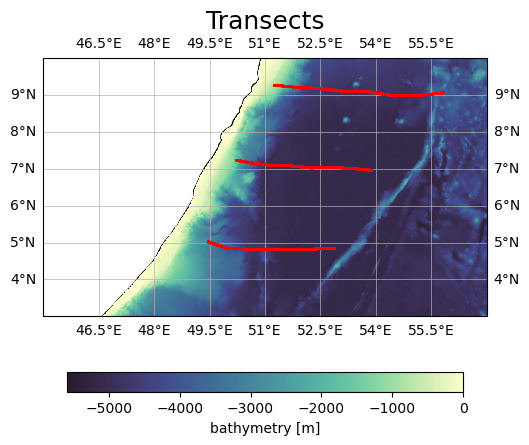

In [13]:
#PLOT TRANSECTS 

# plot track
ax = plt.axes(projection=ccrs.PlateCarree())
ax.scatter(trs1.lon, trs1.lat, transform=ccrs.PlateCarree(), marker = 'o', s= 1, color = 'red',zorder=3)
ax.scatter(trs2.lon, trs2.lat, transform=ccrs.PlateCarree(), marker = 'o', s= 1, color = 'red',zorder=3)
ax.scatter(trs3.lon, trs3.lat, transform=ccrs.PlateCarree(), marker = 'o', s= 1, color = 'red',zorder=3)
# Plot bathymetry
cm = ax.pcolormesh(bathy.lon, bathy.lat, bathy_masked, cmap=cmocean.cm.deep_r, shading='auto', zorder=2)
ax.coastlines()
ax.gridlines(draw_labels=True,linewidth=0.5, zorder=4)
ax.set_extent((45, 57, 3, 10))
ax.set_title("Transects", fontsize=18)
plt.colorbar(cm,location='bottom',shrink=0.8, label = 'bathymetry [m]')

## CTD

In [14]:
#loading the data
datadir = r'/Users/areti/Downloads/results2/somalia/results/ctd.zarr'
ctd = xr.open_zarr(datadir).compute()
ctd

<xarray.Dataset> Size: 1MB
Dimensions:      (trajectory: 24, obs: 1021)
Coordinates:
  * obs          (obs) int32 4kB 0 1 2 3 4 5 6 ... 1015 1016 1017 1018 1019 1020
  * trajectory   (trajectory) int64 192B 38 39 40 41 42 43 ... 56 57 58 59 60 61
Data variables:
    lat          (trajectory, obs) float32 98kB 5.03 5.03 5.03 ... nan nan nan
    lon          (trajectory, obs) float32 98kB 49.45 49.45 49.45 ... nan nan
    max_depth    (trajectory, obs) float32 98kB -2.776e+03 -2.776e+03 ... nan
    min_depth    (trajectory, obs) float32 98kB -11.0 -11.0 -11.0 ... nan nan
    raising      (trajectory, obs) float32 98kB 0.0 0.0 0.0 0.0 ... nan nan nan
    salinity     (trajectory, obs) float32 98kB 34.97 34.97 34.98 ... nan nan
    temperature  (trajectory, obs) float32 98kB 26.26 26.26 26.26 ... nan nan
    time         (trajectory, obs) datetime64[ns] 196kB 2024-09-17T23:12:00 ....
    winch_speed  (trajectory, obs) float32 98kB 1.0 1.0 1.0 1.0 ... nan nan nan
    z            (trajectory, obs) float32 98kB -11.0 -21.0 -31.0 ... nan nan
Attributes:
    Conventions:            CF-1.6/CF-1.7
    feature_type:           trajectory
    ncei_template_version:  NCEI_NetCDF_Trajectory_Template_v2.0
    parcels_kernels:        NewParticle_sample_salinity_sample_temperature_ct...
    parcels_mesh:           spherical
    parcels_version:        3.1.2

In [15]:
# take difference in obs direction
# during descent: diff < 0
dz = ctd.z.diff('obs') 
# using the 'diff' operator reduces the axis size by one
# copy dummy data (first obs entry of original array) to fill it up again
dz = xr.concat([dz.isel(obs=0),dz],dim='obs')
dz = dz.load()
dz['obs'] = np.arange(0,dz.obs.count()) # fixes bug where 'obs' index would occur double

In [16]:
# choose only the descent
ctd_descent = ctd.where(dz<0).compute()

#Cut off the nan entries that occur after a certain value obs_max
obs_max = int(ctd.z.argmin(dim='obs').max().compute())
ctd_descent = ctd_descent.isel(obs=slice(0,obs_max))

# find maximum depth over all the trajectories
traj_maxdepth = ctd.z.argmin(dim='obs').argmax(dim='trajectory').compute()
ctd_descent['obs'] = ctd_descent.z.isel(trajectory=traj_maxdepth)
ctd_descent = ctd_descent.rename({'obs':'depth'})

In [17]:
#indices for transects (south to north) 
trs1_idx = slice(0,8) #transect 1
trs2_idx = slice(8,16) #transect 2
trs3_idx = slice(16,24) #transect 3 

In [18]:
ctd_trs1 = ctd_descent.isel(trajectory=trs1_idx)
ctd_trs2 = ctd_descent.isel(trajectory=trs2_idx)
ctd_trs3 = ctd_descent.isel(trajectory=trs3_idx)

In [19]:
ctd_trs1 = ctd_trs1.isel(depth= slice(0,15))
ctd_trs2 = ctd_trs2.isel(depth= slice(0,15))
ctd_trs3 = ctd_trs3.isel(depth= slice(0,15))

In [20]:
ctd_trs1

<xarray.Dataset> Size: 5kB
Dimensions:      (trajectory: 8, depth: 15)
Coordinates:
  * depth        (depth) float32 60B -11.0 -21.0 -31.0 ... -131.0 -141.0 -151.0
  * trajectory   (trajectory) int64 64B 38 39 40 41 42 43 44 45
Data variables:
    lat          (trajectory, depth) float32 480B 5.03 5.03 5.03 ... 4.854 4.854
    lon          (trajectory, depth) float32 480B 49.45 49.45 ... 52.86 52.86
    max_depth    (trajectory, depth) float32 480B -2.776e+03 ... -5.092e+03
    min_depth    (trajectory, depth) float32 480B -11.0 -11.0 ... -11.0 -11.0
    raising      (trajectory, depth) float32 480B 0.0 0.0 0.0 ... 0.0 0.0 0.0
    salinity     (trajectory, depth) float32 480B 34.97 34.97 ... 35.12 35.16
    temperature  (trajectory, depth) float32 480B 26.26 26.26 ... 19.69 19.13
    time         (trajectory, depth) datetime64[ns] 960B 2024-09-17T23:12:00 ...
    winch_speed  (trajectory, depth) float32 480B 1.0 1.0 1.0 ... 1.0 1.0 1.0
    z            (trajectory, depth) float32 480B -11.0 -21.0 ... -141.0 -151.0
Attributes:
    Conventions:            CF-1.6/CF-1.7
    feature_type:           trajectory
    ncei_template_version:  NCEI_NetCDF_Trajectory_Template_v2.0
    parcels_kernels:        NewParticle_sample_salinity_sample_temperature_ct...
    parcels_mesh:           spherical
    parcels_version:        3.1.2

## Velocity components parallel and perpendicular to the coast


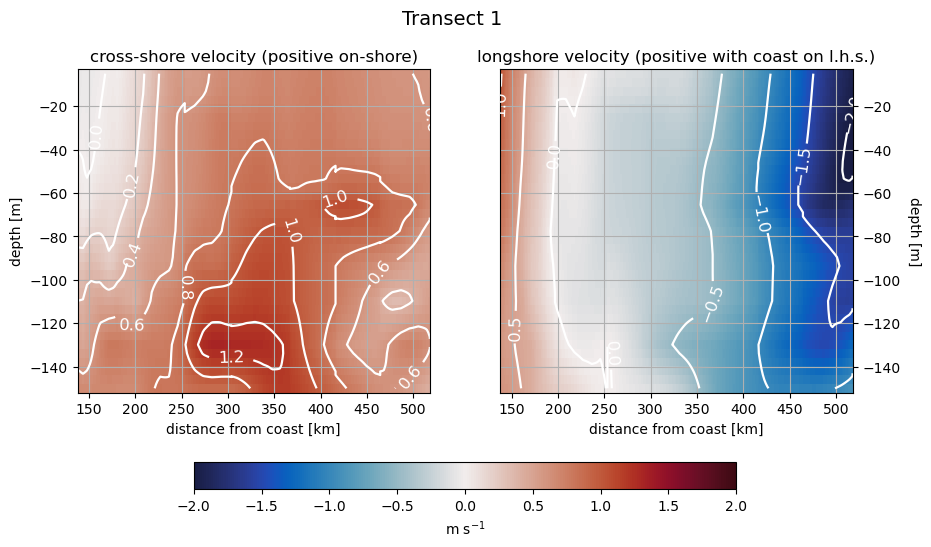

In [21]:
#Transect 1
trs1= dist_shore(adcp=trs1, lon0=lon_1_shore,lat0=lat_1_shore)

horiz_vel(adcp=trs1, title='Transect 1')

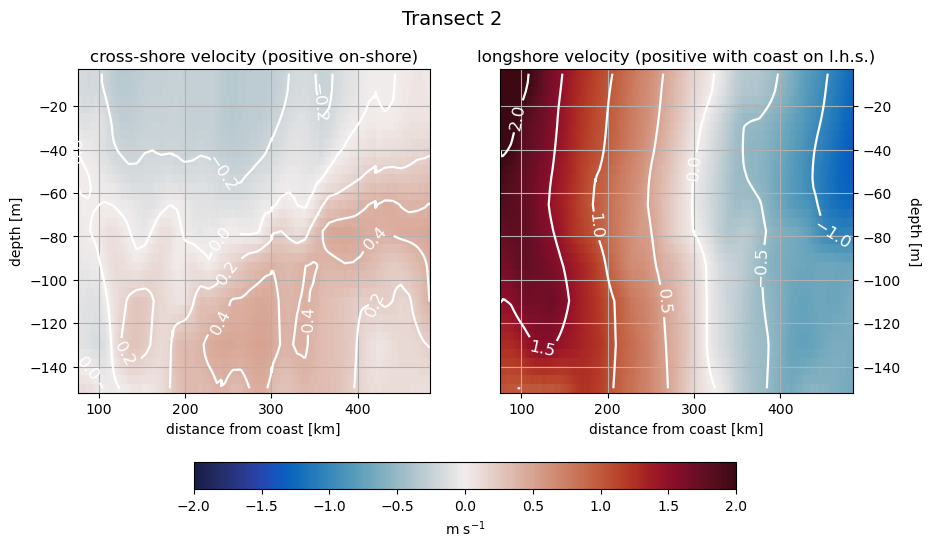

In [22]:
#Transect 3
trs2= dist_shore(adcp=trs2, lon0=lon_2_shore,lat0=lat_2_shore)
horiz_vel(adcp=trs2, title='Transect 2')

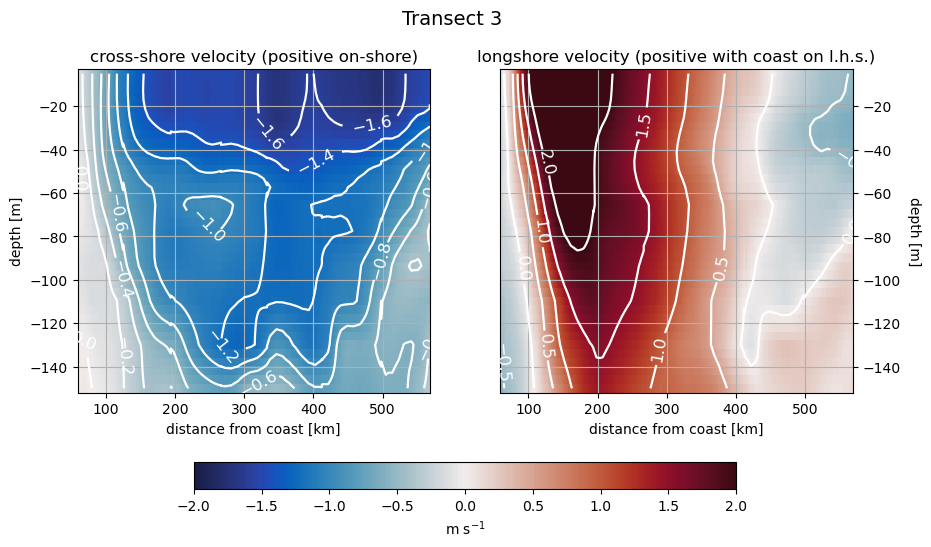

In [23]:
#Transect 3
trs3= dist_shore(adcp=trs3, lon0=lon_3_shore,lat0=lat_3_shore)
horiz_vel(adcp=trs3, title='Transect 3')

## Vertical velocity

I focused on the horizontal velocities and the volume transport since that is our research question, if i have time i will look into it 

In [24]:
#Transect 1

#vertical_vel(data=trs1, title='Transect 1')

In [25]:
#Transect 2
#vertical_vel(data=trs2, title='Transect 2')

In [26]:
#Transect 3
#vertical_vel(data=trs3, title='Transect 3')

## Scaling Numbers 

Calculating Rossby, Ekman and Reynolds numbers for scaling methods

In [27]:
def f_func(lat):

    'Function that calculates the Coriolis frequency'
    omega = 7.2921159e-5
    lat_rad = np.radians(lat)
    f = 2*omega*np.sin(lat_rad)

    return f 

In [28]:
lat1 = trs1.lat.mean()
lat2 = trs2.lat.mean()
lat3 = trs3.lat.mean()

f_1 = f_func(lat1)
f_2 = f_func(lat2)
f_3 = f_func(lat3)

print('Coriolis requencies are', f_1.values,f_2.values, f_3.values, 'hence we can use an ored of magnitude of', 1e-5)

Coriolis requencies are 1.232886e-05 1.797328e-05 2.3068413e-05 hence we can use an ored of magnitude of 1e-05


In [29]:
#so we can say 
fo = 1e-5
U = 1e-1 
L = 1e+5

In [30]:
#Rossby number
Rossby_num = U/(fo*L)
Rossby_num

0.1

In [31]:
# Ekmann number 

In [32]:
K_h = 1e-6
Ekman_h = K_h/(fo*(L**2))

In [33]:
Ekman_h

9.999999999999998e-12

In [34]:
#Reynolds number
Reynolds_num = U*L/K_h
Reynolds_num

10000000000.0

## Plots of V (meridional velocity) measurments

In [35]:
def V_plot(data,title):
    ' Meridional velocity plot (V)'
    fig = plt.figure(figsize=(8,7))
    ax1 = fig.add_subplot(121)
    norm = mcolors.CenteredNorm(halfrange=2)
    cmap = cmocean.cm.balance
    ax1.set_title(f'Meridional velocity V {title}')
    p1 = ax1.pcolormesh(data.lon, data.z, data.V, norm=norm, cmap=cmap)
    
    ax2 = fig.add_subplot(122)
    ax2.set_title(f'Zonal velocity U {title}')
    p2 = ax2.pcolormesh(data.lon, data.z, data.U, norm=norm, cmap=cmap)
#plt.colorbar(p2, shrink=0.7, orientation="horizontal", label=r"m s$^{-1}$")

## Calculate the Volume  transport at the first 150 meters

Probably keep the np.trapezoid calculation

In [36]:
Flux= np.trapezoid(trs3.Ulong, trs3.s*1000, axis=1)
T = np.trapezoid(Flux, trs3.z)
T = (T/1e+6).item()

In [37]:
def Vol_T(data):
    Flux= np.trapezoid(data.Ulong, data.s*1000, axis=1)
    T = np.trapezoid(Flux, data.z)
    T = (T/1e+6).item()
    return T

In [38]:
trs1["Vol_Transport_longshore"]  = Vol_T(data = trs1)
trs1.assign_attrs({"long_name": "longshore volume Transport", "units": "Sv"})
trs2["Vol_Transport_longshore"]  = Vol_T(data = trs2)
trs2.assign_attrs({"long_name": "longshore volume Transport", "units": "Sv"})
trs3["Vol_Transport_longshore"]  = Vol_T(data = trs3)
trs3.assign_attrs({"long_name": "longshore volume Transport", "units": "Sv"})

<xarray.Dataset> Size: 737kB
Dimensions:                  (trajectory: 37, obs: 495)
Coordinates:
  * obs                      (obs) int32 2kB 1233 1234 1235 ... 1725 1726 1727
  * trajectory               (trajectory) int64 296B 1 2 3 4 5 ... 34 35 36 37
    z                        (trajectory) float32 148B -150.0 -146.0 ... -5.0
    s                        (obs) float32 2kB 59.4 59.4 59.4 ... 568.3 568.3
Data variables:
    U                        (trajectory, obs) float32 73kB -0.3056 ... 0.9907
    V                        (trajectory, obs) float32 73kB -0.4819 ... -1.154
    lat                      (trajectory, obs) float32 73kB 9.267 ... 9.062
    lon                      (trajectory, obs) float32 73kB 51.25 ... 55.82
    time                     (trajectory, obs) datetime64[ns] 147kB 2024-09-2...
    Ucross                   (trajectory, obs) float64 147kB 0.02327 ... -1.435
    Ulong                    (trajectory, obs) float64 147kB -0.5702 ... -0.5029
    Vol_Transport_longshore  float64 8B 54.8
Attributes:
    Conventions:            CF-1.6/CF-1.7
    feature_type:           trajectory
    ncei_template_version:  NCEI_NetCDF_Trajectory_Template_v2.0
    parcels_kernels:        NewParticle_sample_velocity
    parcels_mesh:           spherical
    parcels_version:        3.1.2
    long_name:              longshore volume Transport
    units:                  Sv

In [39]:
print('\n Volume Transport at first transect =',trs1["Vol_Transport_longshore"].values ,'Sv \n', 
      'Volume Transport at second transect =',trs2["Vol_Transport_longshore"].values,'Sv \n',
      'Volume Transport at third transect =',trs3["Vol_Transport_longshore"].values,'Sv \n')


 Volume Transport at first transect = -27.67567157784081 Sv 
 Volume Transport at second transect = 19.754913938075337 Sv 
 Volume Transport at third transect = 54.80451124845642 Sv 



In [40]:
#trapezoidal rule or Riemann sum for intergration, first along the transect as dUlong varies with depth and then over dz 

def Volume_transport(data):
    
    # depth from shallow (0m) to deep (-150m)
    data = data.sortby("z", ascending =False) 
    dz = np.abs(np.diff(data.z))  # Compute depth intervals
    
    # Pad last dz with same value for uniformity
    dz = np.append(dz, dz[-1])
    dz.shape
    #create the dx as distance bewtween each point 
    dx = np.abs(np.diff(data.s)) 
    dx = np.append(dx, dx[-1])

   # print(dx)
    #calculate volume transport 
    X = []
    V = 0 
    for j in range(len(data.trajectory)): #integrate over depth
        s1 = 0 
        for i in range(len(data.obs)):
            #print(i)
            Ui = data.Ulong.isel(obs=i, trajectory=j) #integrate along the transect since the Ulong varies along it 
            s1 += Ui*dx[i]
           
        X.append(s1)
    
        S = X[j]*(-dz[j])
        V +=S 
      
    #Convert from m^3/s to Sv
    V =V/1e+6
    return V


In [43]:
#trs1["Vol_Transport_longshore"]  = Volume_transport(data = trs1).assign_attrs({"long_name": "longshore volume Transport", "units": "Sv"})
#trs2["Vol_Transport_longshore"]  = Volume_transport(data = trs2).assign_attrs({"long_name": "longshore volume Transport", "units": "Sv"})
#trs3["Vol_Transport_longshore"]  = Volume_transport(data = trs3).assign_attrs({"long_name": "longshore volume Transport", "units": "Sv"})

In [44]:
print('\n Volume Transport at first transect =',trs1["Vol_Transport_longshore"].values ,'Sv \n', 
      'Volume Transport at second transect =',trs2["Vol_Transport_longshore"].values,'Sv \n',
      'Volume Transport at third transect =',trs3["Vol_Transport_longshore"].values,'Sv \n')


 Volume Transport at first transect = -27.67567157784081 Sv 
 Volume Transport at second transect = 19.754913938075337 Sv 
 Volume Transport at third transect = 54.80451124845642 Sv 



## Plots to compare to Bibliography

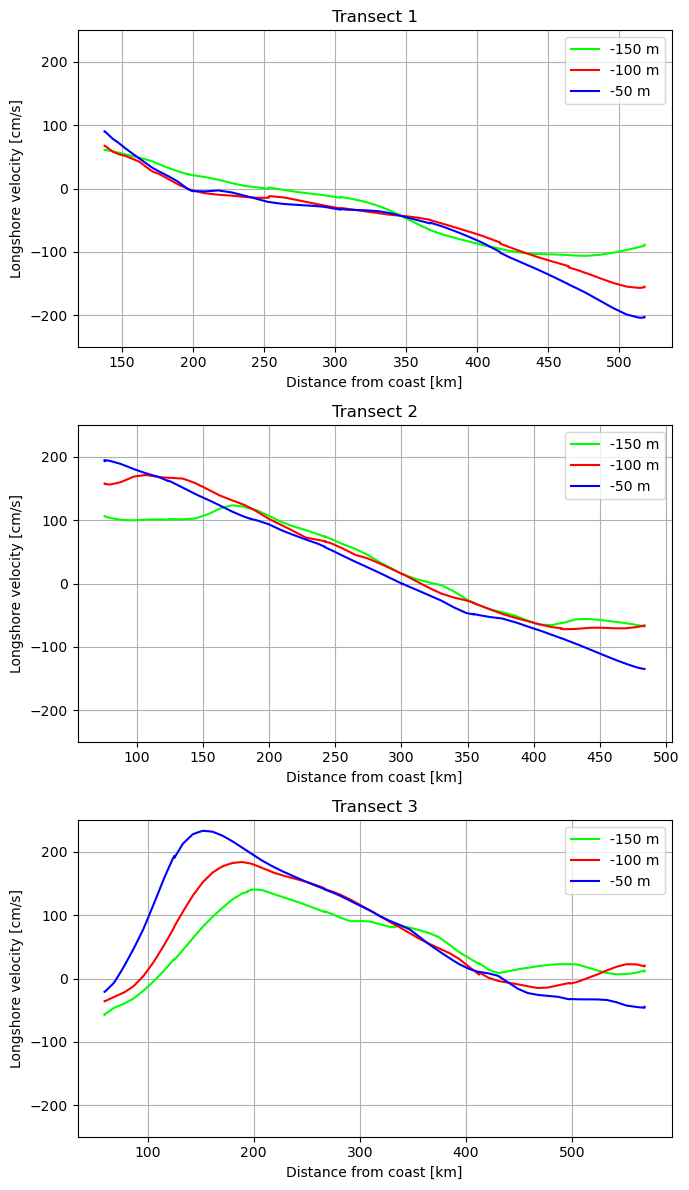

In [45]:
#plot
trs1.s
fig, ax = plt.subplots(ncols=1, nrows=3,figsize=(7,12))
transects= [trs1, trs2, trs3]
titles = ['Transect 1', 'Transect 2', 'Transect 3']
for i in range(3):
    trs = transects[i]
    title = titles[i]
    ax[i].set_title(f'{title}')
    ax[i].set_ylabel('Longshore velocity [cm/s]')
    ax[i].set_xlabel('Distance from coast [km]')
    ax[i].plot(trs.s, trs.Ulong.isel(trajectory = 0)*100, color = 'lime', label = '-150 m')
    ax[i].plot(trs.s, trs.Ulong.isel(trajectory = 12)*100, color = 'red', label = '-100 m')
    ax[i].plot(trs.s, trs.Ulong.isel(trajectory = 25)*100, color = 'blue', label = '-50 m')
    #ax[i].set_xlim([-140,-550])
    # Flip the x-axis
    #ax[i].invert_xaxis()
    ax[i].set_ylim([-250, 250])
    ax[i].legend()
    ax[i].grid()
plt.tight_layout()


## ERA5 

In [46]:
ds = xr.open_dataset(r'/Users/areti/Downloads/bde7b7b36dbf193465a4ea3abdecd11f/data_stream-oper_stepType-instant.nc')

In [47]:
ds.sst.min() - 273

<xarray.DataArray 'sst' ()> Size: 4B
array(18.75415, dtype=float32)
Coordinates:
    number   int64 8B ...

In [48]:
trs1.lon

<xarray.DataArray 'lon' (trajectory: 37, obs: 418)> Size: 62kB
array([[49.447758, 49.447758, 49.447758, ..., 52.86433 , 52.86433 ,
        52.86433 ],
       [49.447758, 49.447758, 49.447758, ..., 52.86433 , 52.86433 ,
        52.86433 ],
       [49.447758, 49.447758, 49.447758, ..., 52.86433 , 52.86433 ,
        52.86433 ],
       ...,
       [49.447758, 49.447758, 49.447758, ..., 52.86433 , 52.86433 ,
        52.86433 ],
       [49.447758, 49.447758, 49.447758, ..., 52.86433 , 52.86433 ,
        52.86433 ],
       [49.447758, 49.447758, 49.447758, ..., 52.86433 , 52.86433 ,
        52.86433 ]], shape=(37, 418), dtype=float32)
Coordinates:
  * obs         (obs) int32 2kB 0 1 2 3 4 5 6 7 ... 411 412 413 414 415 416 417
  * trajectory  (trajectory) int64 296B 1 2 3 4 5 6 7 8 ... 31 32 33 34 35 36 37
    z           (trajectory) float32 148B -150.0 -146.0 -141.9 ... -9.028 -5.0
    s           (obs) float32 2kB 137.7 137.7 137.7 137.7 ... 517.8 517.8 517.8
Attributes:
    axis:           X
    long_name:      
    standard_name:  longitude
    units:          degrees_east

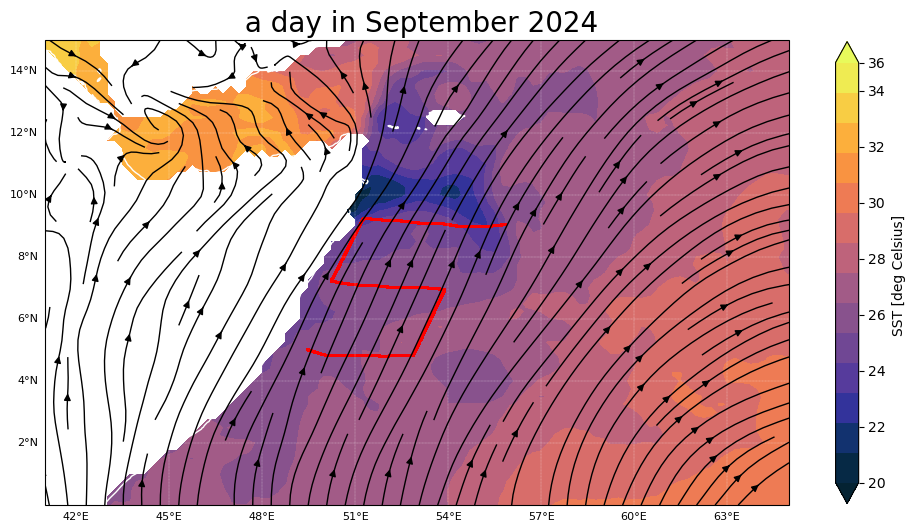

In [49]:
ds = ds.sortby('latitude', ascending=True)
Lat = ds['latitude'].values
Lon = ds['longitude'].values 
#levs= 50
#ax[i].set_extent([5,30,25,45], crs = ccrs.PlateCarree())
#if data.attrs['units'] == 'ms-1':

#colorbar properties 
vmin = 20
vmax = 35
levs= 15
#magn = data.values
U = ds.u10.isel(valid_time=100).values
V = ds.v10.isel(valid_time=100).values
SST = ds.sst.isel(valid_time=100).values - 273.15

fig = plt.figure(figsize=(12,12))
ax = fig.add_subplot(1, 1, 1, projection=ccrs.PlateCarree())
projection = ccrs.PlateCarree()
plt.title(' a day in September 2024', fontsize=20)
ax.scatter(adcp.lon, adcp.lat, transform=ccrs.PlateCarree(), marker = 'o', s= 1, color = 'red',zorder=2)

mp = ax.contourf(Lon, Lat, SST, cmap=cmocean.cm.thermal, transform=ccrs.PlateCarree(),vmax=vmax,vmin=vmin,
                 extend='both',levels = np.linspace(vmin,vmax,levs))

#skip = (slice(None, None, 30), slice(None, None, 30))

#ax.quiver(trs1.lon.isel(trajectory=36),trs1.lat.isel(trajectory=36),trs1.U.isel(trajectory=36),trs1.V.isel(trajectory=36),transform=ccrs.PlateCarree(), 
#          scale=30,width=0.0025, headwidth=3, minlength=0,zorder=3, color = 'green')
ax.streamplot(Lon,Lat,U,V,transform=ccrs.PlateCarree(), 
                     arrowstyle='-|>',arrowsize=1,zorder=3, color='k',density=1.5,minlength=0.1,
                     maxlength=4.0, integration_direction='both',start_points=None,linewidth=1,
                     broken_streamlines=True)
#plot data
ax.coastlines(color='white')
gl = ax.gridlines(color='white', draw_labels= True,  x_inline=False, y_inline=False, linestyle ='--', linewidth=0.2)
gl.xlabel_style = {'fontsize': 8,'rotation': 0}
gl.ylabel_style = {'fontsize': 8}
gl.right_labels = gl.top_labels = False
ax.set_extent((41, 65, 0, 15))
#                   levels = np.linspace(vmin,vmax,levs), zorder=1)
cbar= plt.colorbar(mp,ax=ax,shrink = 0.5,  location = 'right', extend='both',label = 'SST [deg Celsius] ')
cbar.set_ticks(np.arange(20,vmax+2,2))


In [50]:

skip = (slice(None, None, 5))
depths = [ 36, 24, 12, 0]

    fig, ax = plt.subplots(figsize=(10, 6))
    for i in depths:
        
        lon = trss.lon.isel(trajectory=i)
        Us = trss.U.isel(trajectory=i)
        Vs = trss.V.isel(trajectory=i)
        z = trss.z.isel(trajectory=i)
        quiver = ax.quiver(lon[skip] ,z, Us[skip],Vs[skip], 
                    scale=30, width=0.002, headwidth=3, minlength=0.1)

#U = ds.u10.sel(latitude=4.5, longitude=slice(49,50))



IndentationError: unexpected indent (2435100869.py, line 4)

In [ ]:
U

In [ ]:
lon = trs1.lon.isel(trajectory=36)

In [ ]:
skip = (slice(None, None, 5))
lon[skip]

In [ ]:
underw = xr.open_zarr("/Users/areti/Downloads/results2/somalia/results/ship_underwater_st.zarr").compute()

In [ ]:
underw

In [ ]:
ctd_trs1

In [ ]:
adcp.lon

In [ ]:
adcp = trs1
# Calculate and plot the velocity components parallel and perpendicular to the coast.
adcp_surf = adcp.isel(trajectory=36).compute()
# calculations

angle = np.arctan2(lat_3_shore - lat_1_shore,lon_3_shore - lon_1_shore)  # Angle of alongshore direction (

# Compute cross-shore and alongshore velocity components using sines and cosines
Ulong = adcp.U * np.cos(angle) + adcp.V * np.sin(angle)
Ucross = -adcp.U * np.sin(angle) + adcp.V * np.cos(angle)

adcp["Ucross"] = Ucross.assign_attrs(
    {"long_name": "cross-shore velocity", "units": "m s-1"}
)
adcp["Ulong"] = Ulong.assign_attrs(
    {"long_name": "longshore velocity", "units": "m s-1"}
)

# figure settings
fig = plt.figure(figsize=(10, 6))
#fig.suptitle(f'{title}', fontsize=14) 
norm = mcolors.CenteredNorm(halfrange=2)
cmap = cmocean.cm.balance
#landmask = xr.where(((adcp.U == 0) & (adcp.V == 0)), 1, np.nan)
#S = adcp.s.broadcast_like(adcp.lon)

# cross-shore velocity plot
ax1 = fig.add_subplot(121)
#plot adcp velocities
p = ax1.pcolormesh(adcp.lon, adcp.z, adcp.Ucross, norm=norm, cmap=cmap)

#
fontsize = 10
inline =0.5
inline_sp = 10
linewidth=3
#plot ctd isothermos 
temp = ax1.contour(ctd_trs1.lon, ctd_trs1.z, ctd_trs1.temperature,colors = 'black',linewidths= 0.7, linestyles='-')
ax1.clabel(temp,inline= inline,fontsize = fontsize,colors='black',inline_spacing = inline_sp)
#plot contours of equal velocity 
levs = np.arange(-2, 2.5, 0.2)
vel = ax1.contour(adcp.lon.isel(trajectory=36), adcp.z, adcp.Ucross,colors='white',linewidths= 1.6, linestyles='-', levels= levs)
ax1.clabel(vel,inline= inline,fontsize = fontsize,colors='white',inline_spacing = inline_sp)
# p = ax1.pcolormesh(S / 1000, adcp.z, adcp.Ucross, norm=norm, cmap=cmap)
#ax1.pcolormesh(S / 1000, adcp.z, landmask, cmap="binary_r")
ax1.set_ylabel("depth [m]")
#ax1.set_xlabel("distance from coast [km]")
ax1.set_xlabel('Longitude')
ax1.set_title("cross-shore velocity (positive off-shore)")
ax1.grid()
#plt.xlim([0,-600])

# alongshore velocity plot
ax2 = fig.add_subplot(122, sharey=ax1)
ax2.yaxis.tick_right()
p2 = ax2.pcolormesh(adcp.lon, adcp.z, adcp.Ulong, norm=norm, cmap=cmap)
#p2 = ax2.pcolormesh(S / 1000, adcp.z, adcp.Ulong, norm=norm, cmap=cmap)
# ax2.pcolormesh(S / 1000, adcp.z, landmask, cmap="binary_r")
#plot ctd isothermos 
temp = ax2.contour(ctd_trs1.lon, ctd_trs1.z, ctd_trs1.temperature,colors = 'black',linewidths= 0.7, linestyles='-')
ax2.clabel(temp,inline= inline,fontsize = fontsize,colors='black',inline_spacing = inline_sp)
#plot contours of equal velocity 
levs = np.arange(-2, 2.5, 0.2)
vel = ax2.contour(adcp.lon.isel(trajectory=36), adcp.z, adcp.Ulong,colors='white',linewidths= 1.6, linestyles='-', levels= levs)
ax2.clabel(vel,inline= inline,fontsize = fontsize,colors='white',inline_spacing = inline_sp)

ax2.set_ylabel("depth [m]", rotation=270, labelpad=15)
ax2.set_xlabel('Longitude')
#ax2.set_xlabel("distance from coast [km]")
ax2.set_title("longshore velocity (positive with coast on l.h.s.)")
ax2.yaxis.set_label_position("right")
ax2.grid()
fig.colorbar(
    p, ax=[ax1, ax2], shrink=0.7, orientation="horizontal", label=r"m s$^{-1}$"

)
#

In [ ]:
adcp


In [ ]:
adcp_d = adcp.sortby("z", ascending=False)
adcp_d

In [ ]:
trs1

In [66]:
ctd = ctd_trs1
ctd_trs1["pressure"] = gsw.conversions.p_from_z(ctd.depth, ctd.lat).assign_attrs({"long_name": "sea pressure", "units": "dbar"})
CT = gsw.CT_from_t(ctd.salinity, ctd.temperature, ctd.pressure)
Rho = gsw.density.rho(ctd.salinity, CT, ctd.pressure)
ctd.lon

<xarray.DataArray 'lon' (trajectory: 8, depth: 15)> Size: 480B
array([[49.447758, 49.447758, 49.447758, 49.447758, 49.447758, 49.447758,
        49.447758, 49.447758, 49.447758, 49.447758, 49.447758, 49.447758,
        49.447758, 49.447758, 49.447758],
       [49.977722, 49.977722, 49.977722, 49.977722, 49.977722, 49.977722,
        49.977722, 49.977722, 49.977722, 49.977722, 49.977722, 49.977722,
        49.977722, 49.977722, 49.977722],
       [50.486423, 50.486423, 50.486423, 50.486423, 50.486423, 50.486423,
        50.486423, 50.486423, 50.486423, 50.486423, 50.486423, 50.486423,
        50.486423, 50.486423, 50.486423],
       [50.939945, 50.939945, 50.939945, 50.939945, 50.939945, 50.939945,
        50.939945, 50.939945, 50.939945, 50.939945, 50.939945, 50.939945,
        50.939945, 50.939945, 50.939945],
       [51.50756 , 51.50756 , 51.50756 , 51.50756 , 51.50756 , 51.50756 ,
        51.50756 , 51.50756 , 51.50756 , 51.50756 , 51.50756 , 51.50756 ,
        51.50756 , 51.50756 , 51.50756 ],
       [51.94962 , 51.94962 , 51.94962 , 51.94962 , 51.94962 , 51.94962 ,
        51.94962 , 51.94962 , 51.94962 , 51.94962 , 51.94962 , 51.94962 ,
        51.94962 , 51.94962 , 51.94962 ],
       [52.38312 , 52.38312 , 52.38312 , 52.38312 , 52.38312 , 52.38312 ,
        52.38312 , 52.38312 , 52.38312 , 52.38312 , 52.38312 , 52.38312 ,
        52.38312 , 52.38312 , 52.38312 ],
       [52.86433 , 52.86433 , 52.86433 , 52.86433 , 52.86433 , 52.86433 ,
        52.86433 , 52.86433 , 52.86433 , 52.86433 , 52.86433 , 52.86433 ,
        52.86433 , 52.86433 , 52.86433 ]], dtype=float32)
Coordinates:
  * depth       (depth) float32 60B -11.0 -21.0 -31.0 ... -131.0 -141.0 -151.0
  * trajectory  (trajectory) int64 64B 38 39 40 41 42 43 44 45
Attributes:
    axis:           X
    long_name:      
    standard_name:  longitude
    units:          degrees_east

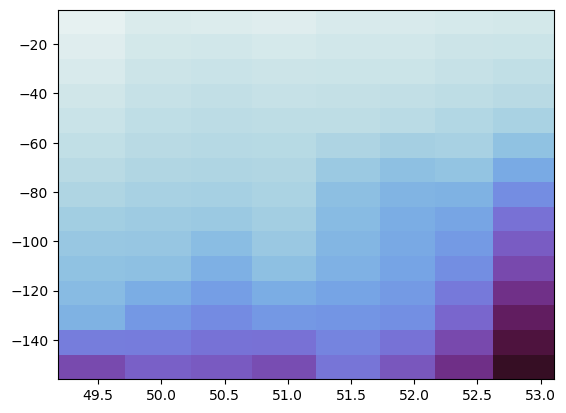

In [75]:
dens_plot = plt.pcolormesh(ctd.lon.isel(depth=0), ctd.depth, Rho.transpose(), shading='nearest', cmap= cmocean.cm.dense)